<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/VGG16%20final/100_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Preprocessing
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

#Model dan Augmentasi
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import layers, models, optimizers
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16

# Evaluasi
#import torch
#import torchvision.models as models
#from thop import profile
from sklearn.metrics import confusion_matrix, classification_report

#Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"smjayyy","key":"07729aa6a210c0f9baaeed1cf96a6a3b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
##link dataset in Kaggle.com
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
100% 160M/161M [00:05<00:00, 34.2MB/s]
100% 161M/161M [00:05<00:00, 31.7MB/s]


In [ ]:
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

In [ ]:
dataset_dir = '/content/data'

In [ ]:
print(os.listdir(dataset_dir))

['Gray_Leaf_Spot', 'Blight', 'Healthy', 'Common_Rust']


In [ ]:
IMAGE_SIZE_vgg16 = 224

In [ ]:
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_SIZE_vgg16, IMAGE_SIZE_vgg16))
        img_list.append(np.array(img))
        label_list.append(str(label))

In [ ]:
X = []
Z = []

In [ ]:
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(class_name, class_dir, X, Z)

100%|██████████| 1146/1146 [00:05<00:00, 192.93it/s]


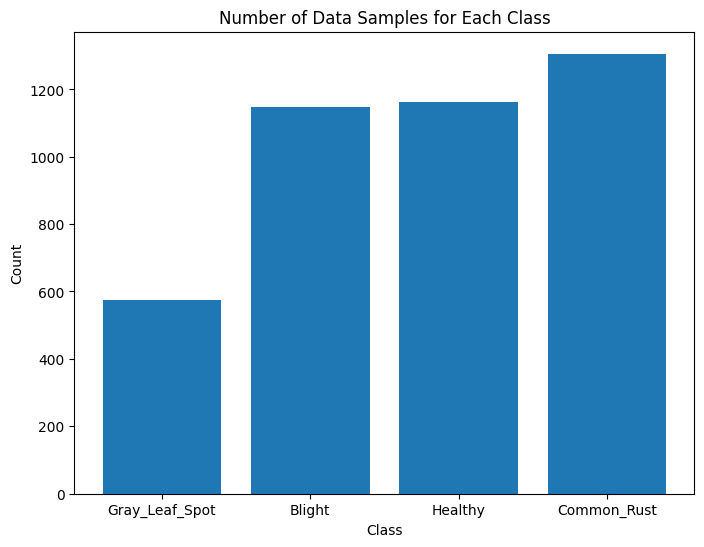

In [ ]:
import matplotlib.pyplot as plt

# Menghitung jumlah data untuk setiap kelas
class_counts = {class_name: Z.count(class_name) for class_name in set(Z)}

# Menampilkan visualisasi jumlah data
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Data Samples for Each Class')
plt.show()

In [ ]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, num_classes=len(le.classes_))

# Konversi ke array numpy
X = np.array(X)

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Jumlah Data Train adalah :", len(X_train))
print("Jumlah Data Test adalah :", len(X_test))

Jumlah Data Train adalah : 3350
Jumlah Data Test adalah : 838


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotasi gambar hingga 40 derajat
    zoom_range=0.2,  # Zoom-in/Zoom-out gambar
    horizontal_flip=True,  # Flipping horizontal gambar
    vertical_flip=True
)

datagen.fit(X_train)

In [ ]:
NUM_CLASSES = 4
LEARNING_RATE = 1e-4

# Fungsi untuk membuat arsitektur VGG16
def build_vgg16(input_shape, num_classes):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Buat model VGG16 tanpa transfer learning
model_vgg16 = build_vgg16(input_shape=(IMAGE_SIZE_vgg16, IMAGE_SIZE_vgg16, 3), num_classes=NUM_CLASSES)

# Kompilasi model
model_vgg16.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

# Ringkasan model
model_vgg16.summary()

history = model_vgg16.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

27/27 [==============================] - 3s 119ms/step


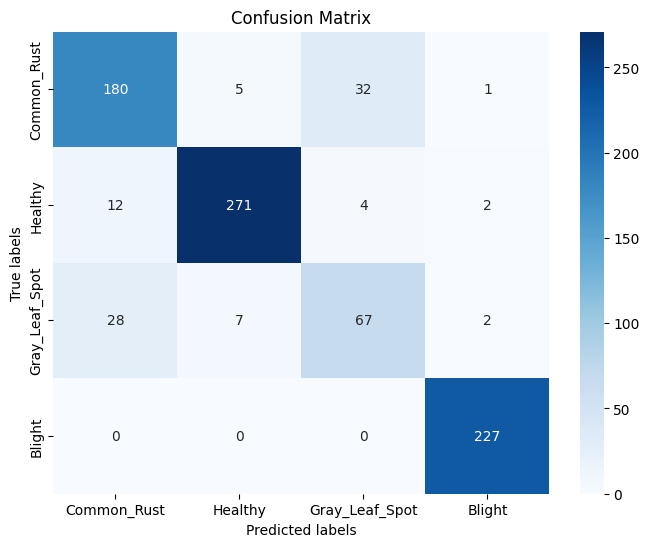


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       218
           1       0.96      0.94      0.95       289
           2       0.65      0.64      0.65       104
           3       0.98      1.00      0.99       227

    accuracy                           0.89       838
   macro avg       0.85      0.85      0.85       838
weighted avg       0.89      0.89      0.89       838



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Y_pred = model_vgg16.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'], yticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(Y_true, Y_pred_classes)

print("\nClassification Report:")
print(class_report)